In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!pip install tensorflow==2.0.0-beta1

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
import pandas as pd
import csv

2.0.0-beta1


In [0]:
root_path = '/content/drive/My Drive/Colab Notebooks/TCP_data/'
file_path = root_path +'test-three.csv'


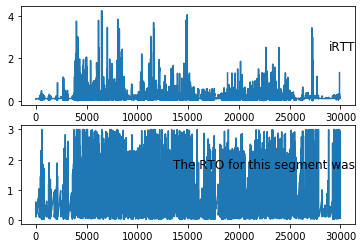

In [0]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('final-test.csv')
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [0]:
%pwd
%cd '/content/drive/My Drive/Colab Notebooks/TCP_data'
%ls

/content/drive/My Drive/Colab Notebooks/TCP_data
 filtered1.csv              finalretrans.csv       final-test.csv
'finalretrans - Copy.csv'   finalretrans-two.csv   test-three.csv


In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('final-test.csv', header=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 0, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11]], axis=1, inplace=True)
print(reframed.head())

    var1(t)   var2(t)
0  0.015677  0.090835
1  0.024019  0.092291
2  0.024019  0.193235
3  0.023512  0.026066
4  0.023512  0.026411


In [0]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pandas import DataFrame, concat

In [0]:
# split into train and test sets
values = reframed.values
n_train = 20000
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(20000, 1, 1) (20000,) (8378, 1, 1) (8378,)


Train on 20000 samples, validate on 8378 samples
Epoch 1/50
20000/20000 - 1s - loss: 166.9096 - val_loss: 456.0328
Epoch 2/50
20000/20000 - 1s - loss: 97.7991 - val_loss: 635.8959
Epoch 3/50
20000/20000 - 1s - loss: 98.2198 - val_loss: 395.2310
Epoch 4/50
20000/20000 - 1s - loss: 97.9988 - val_loss: 274.9518
Epoch 5/50
20000/20000 - 1s - loss: 98.0657 - val_loss: 441.5974
Epoch 6/50
20000/20000 - 1s - loss: 98.0031 - val_loss: 532.9773
Epoch 7/50
20000/20000 - 1s - loss: 98.1101 - val_loss: 437.0827
Epoch 8/50
20000/20000 - 1s - loss: 98.0077 - val_loss: 775.8056
Epoch 9/50
20000/20000 - 1s - loss: 97.9629 - val_loss: 478.1893
Epoch 10/50
20000/20000 - 1s - loss: 97.8918 - val_loss: 294.8920
Epoch 11/50
20000/20000 - 1s - loss: 98.3232 - val_loss: 326.5201
Epoch 12/50
20000/20000 - 1s - loss: 97.9140 - val_loss: 206.7272
Epoch 13/50
20000/20000 - 1s - loss: 98.1052 - val_loss: 527.2690
Epoch 14/50
20000/20000 - 1s - loss: 98.3398 - val_loss: 255.0253
Epoch 15/50
20000/20000 - 1s - loss

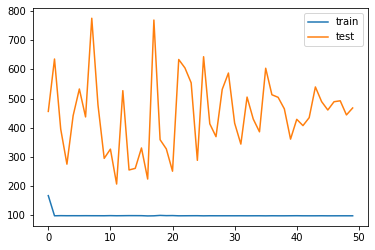

In [0]:
# design network
model = Sequential()
model.add(Dense(50, input_shape=(train_X.shape[1], train_X.shape[2]), activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mape', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 50)             300       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 50)             2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 50)             2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              51        
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________


In [0]:
forecast=[]
for time in range(len(test_X)):
  forecast.append(model.predict(test_X[time:time + 1]))

forecast = forecast[:]
results = np.array(forecast)[:, 0, 0]

In [0]:

from sklearn.metrics import mean_squared_error

[[100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 ...
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]]


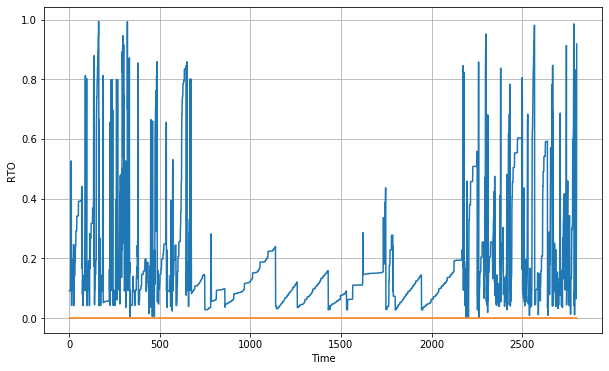

In [0]:
print(tf.keras.metrics.mean_absolute_percentage_error(test_X, results).numpy())

plt.figure(figsize=(10, 6))

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("RTO")
    plt.grid(True)

plot_series(range(len(test_X)), test_y)
plot_series(range(len(test_X)), results)


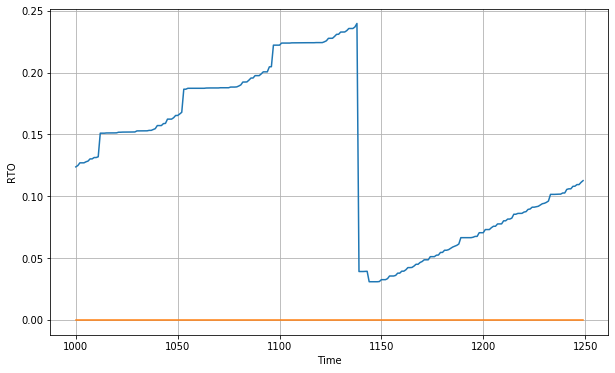

In [0]:
plt.figure(figsize=(10, 6))

plot_series(range(len(test_X))[1000:1250], test_y[1000:1250])
plot_series(range(len(test_X))[1000:1250], results[1000:1250])

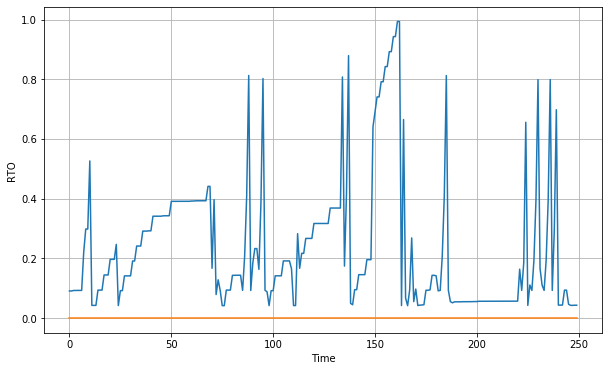

In [0]:
plt.figure(figsize=(10, 6))

plot_series(range(len(test_X))[:250], test_y[:250])
plot_series(range(len(test_X))[:250], results[:250])